In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

spark-2.4.0-bin-hadoop2.7/
spark-2.4.0-bin-hadoop2.7/python/
spark-2.4.0-bin-hadoop2.7/python/setup.cfg
spark-2.4.0-bin-hadoop2.7/python/pyspark/
spark-2.4.0-bin-hadoop2.7/python/pyspark/resultiterable.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/pyspark/
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/pyspark/shell.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/heapq3.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/join.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/version.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/rdd.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/java_gateway.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/find_spark_home.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/_globals.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/worker.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/mllib/
spark-2.4.0-bin-hadoop2.7/python/pyspark/mllib/feature.py
spark-2.4.0-bin-hadoop2.7/python/pyspark

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/LDS9_K273_ONLINE_BuiThiHuong/LDS9_K273_BuiThiHuong_Cuoi_ky/'

/content/gdrive/My Drive/LDS9_K273_ONLINE_BuiThiHuong/LDS9_K273_BuiThiHuong_Cuoi_ky


In [4]:
import pyspark

In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF, Tokenizer
from pyspark.ml.feature import NGram

from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import NaiveBayes, NaiveBayesModel, \
                                      LogisticRegression, LogisticRegressionModel, \
                                      RandomForestClassifier, RandomForestClassificationModel, \
                                      GBTClassifier, GBTClassificationModel
                                      
from pyspark.ml import Pipeline, PipelineModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import time

In [6]:
spark = SparkSession.builder.appName('nlp').getOrCreate()

## Read data

In [7]:
start_time = time.time()

In [8]:
data = spark.read.format('csv').\
                  option("delimiter", ",").\
                  option("header","true").\
                  option("quote", "\"").\
                  option('escape','"').\
                  option("multiLine", "true").\
                  option("inferSchema", "true").\
                  option("parserLib", "UNIVOCITY").\
                  option("ignoreTrailingWhiteSpace","true").\
                  option("ignoreLeadingWhiteSpace", "true").\
                  load('Data/covid_text_classification/Corona_NLP_train.csv') 

In [9]:
data.show(5, False)

+--------+----------+---------+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|UserName|ScreenName|Location |TweetAt   |OriginalTweet                                                                                                                                                                                                                                                                                                         |Sentiment         |
+--------+----------+---------+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
data.show(5, truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 UserName      | 3799                                                                                                                                                                                                                                                                                                                   
 ScreenName    | 48751                                                                                                                                                                                                                                                                                                                  
 Location    

In [11]:
data.columns

['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet', 'Sentiment']

In [12]:
data.select('Sentiment').groupBy('Sentiment').count().show(truncate=False)

+------------------+-----+
|Sentiment         |count|
+------------------+-----+
|Extremely Negative|5481 |
|Neutral           |7713 |
|Positive          |11422|
|Negative          |9917 |
|Extremely Positive|6624 |
+------------------+-----+



In [13]:
data.printSchema()

root
 |-- UserName: integer (nullable = true)
 |-- ScreenName: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- TweetAt: string (nullable = true)
 |-- OriginalTweet: string (nullable = true)
 |-- Sentiment: string (nullable = true)



In [14]:
# check NaN
data.select([sum(when(isnan(col(col_name)),1)
          .otherwise(0)).alias(col_name)
          for col_name in data.columns]).toPandas().T

,0
UserName,0
ScreenName,0
Location,0
TweetAt,0
OriginalTweet,0
Sentiment,0


In [15]:
# check null
data.select([sum(when(col(col_name).isNull(),1)
          .otherwise(0)).alias(col_name)
          for col_name in data.columns]).toPandas().T

,0
UserName,0
ScreenName,0
Location,8594
TweetAt,0
OriginalTweet,0
Sentiment,0


* "OriginalTweet" and "Sentiment" don't have missing values

In [16]:
# data = data.sample(0.01)

In [17]:
data.cache()

DataFrame[UserName: int, ScreenName: int, Location: string, TweetAt: string, OriginalTweet: string, Sentiment: string]

## Data Pre-processing

In [18]:
# create "title_text" column
# data = data.select("*", concat(col("title"),lit(". "),col("text")).alias("title_text"))

In [19]:
# data.show(4, False)

In [20]:
# create "length" column
data = data.withColumn('length', length(data['OriginalTweet']))

In [21]:
data.show(5)

+--------+----------+---------+----------+--------------------+------------------+------+
|UserName|ScreenName| Location|   TweetAt|       OriginalTweet|         Sentiment|length|
+--------+----------+---------+----------+--------------------+------------------+------+
|    3799|     48751|   London|16-03-2020|@MeNyrbie @Phil_G...|           Neutral|   111|
|    3800|     48752|       UK|16-03-2020|advice Talk to yo...|          Positive|   237|
|    3801|     48753|Vagabonds|16-03-2020|Coronavirus Austr...|          Positive|   131|
|    3802|     48754|     null|16-03-2020|My food stock is ...|          Positive|   306|
|    3803|     48755|     null|16-03-2020|Me, ready to go a...|Extremely Negative|   310|
+--------+----------+---------+----------+--------------------+------------------+------+
only showing top 5 rows



In [22]:
data.select('length').agg({'length':'min'}).show()

+-----------+
|min(length)|
+-----------+
|          3|
+-----------+



class: Extremely Negative


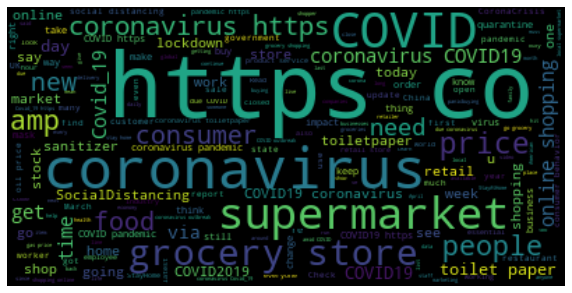

class: Extremely Positive


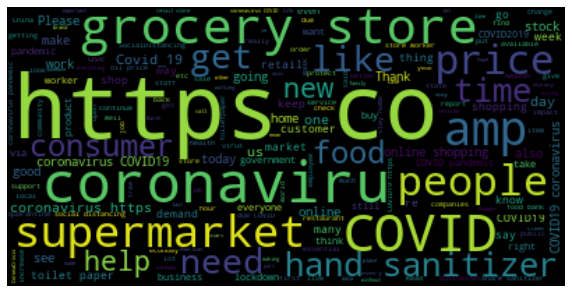

class: Negative


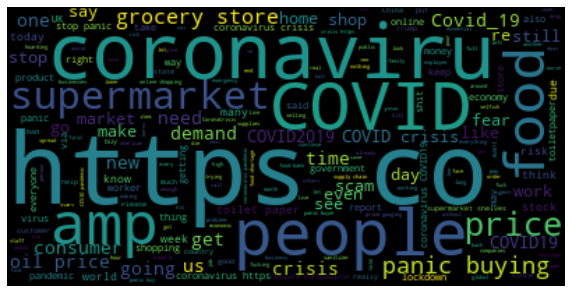

class: Neutral


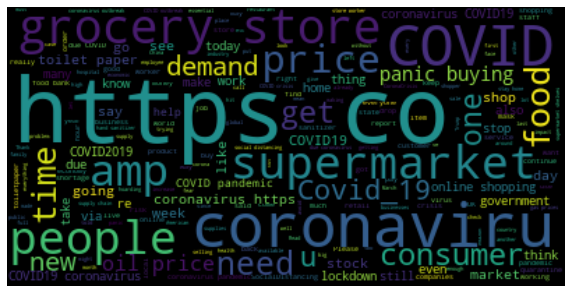

class: Positive


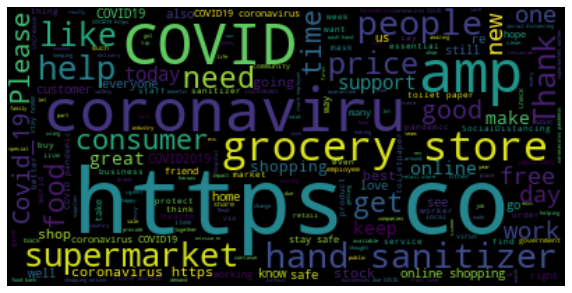

In [23]:
# WordCloud chart of each class
n = 0
data_pdf = data.toPandas()
y = data_pdf['Sentiment']
X = data_pdf[['OriginalTweet']]
stopwordList = StopWordsRemover().getStopWords()
for i in y.sort_values().unique():
    # Tạo text
    text = ""
    for j in X.iloc[y[y==y.unique()[n]].index].iloc[:,0]:
        text = text + " " + j
    # Bieu do WordCloud
    plt.figure(figsize=(10,10))
    wc_text=WordCloud(stopwords = stopwordList)
    wc_text.generate(text)
    print('class:',i)
    plt.imshow(wc_text,interpolation="bilinear")
    plt.axis("off")
    plt.show()
    n=n+1

In [24]:
data.printSchema()

root
 |-- UserName: integer (nullable = true)
 |-- ScreenName: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- TweetAt: string (nullable = true)
 |-- OriginalTweet: string (nullable = true)
 |-- Sentiment: string (nullable = true)
 |-- length: integer (nullable = true)



### TEST

#### Tokenizer (test)

In [25]:
# tokenizer = Tokenizer(inputCol='text', outputCol='words')

# regexTokenizer = RegexTokenizer(inputCol='text', outputCol='words', pattern='\\W')
# # alternatively, pattern="\\W", gaps(False)

# countTokens = udf(lambda words: len(words), IntegerType())

In [26]:
# tokenized = tokenizer.transform(train_data)

# tokenized.select('title_text','words')\
#                   .withColumn('tokens', countTokens(col('words'))).show(5, truncate=False)

In [27]:
# regexTokenized = regexTokenizer.transform(train_data)

# r = regexTokenized.withColumn('tokens', countTokens(col('words')))

In [28]:
# r.show()

#### StopwordsRemover (test)

In [29]:
# remover = StopWordsRemover(inputCol='words', outputCol='filtered')
# r = remover.transform(r)
# r.show(5, truncate=False)

In [30]:
# r.show(5)

#### NGram (test)

In [31]:
# ngram = NGram(n=2, inputCol='words', outputCol='ngrams')

# ngramDataFrame = ngram.transform(r)
# ngramDataFrame.select('class','text','ngrams').show(truncate=False)

#### CountVectorizer (test)

In [32]:
# r.printSchema()

In [33]:
# r.select('tokens').agg({'tokens':'min'}).show()

In [34]:
# # fit a CountVectorizerModel from the corpus
# # cv = CountVectorizer(inputCol='filtered', outputCol='features', vocabSize=500, minDF=1)
# cv = CountVectorizer(inputCol='words', outputCol='features')
# model = cv.fit(r)
# result = model.transform(r)
# result.show(5)

#### TF-IDF (test)

In [35]:
# idf = IDF(inputCol='features', outputCol='tf_idf_features')
# idfModel = idf.fit(result)
# rescaledData = idfModel.transform(result)
# rescaledData.select('features', 'tf_idf_features').show(truncate=False)

#### StringIndexer (test)

In [36]:
# indexer = StringIndexer(inputCol='class',
#                         outputCol='label')

In [37]:
# indexed = indexer.fit(rescaledData)
# clean_data = indexed.transform(rescaledData)

In [38]:
# clean_data.select('label','tf_idf_features').show()

#### Train, Test Splitting (test)

In [39]:
# train_data, test_data = clean_data.randomSplit([0.7,0.3])

In [40]:
# train_data.count()

In [41]:
# test_data.count()

#### Build model (test)

In [42]:
# train_data.columns

In [43]:
# nb = NaiveBayes(featuresCol='tf_idf_features',
#                       labelCol='label')

In [44]:
# nb_model = nb.fit(train_data)

In [45]:
# test_predictions = nb_model.transform(test_data)

In [46]:
# test_predictions.show(5)

## Build first model

### Train, Test Splitting

In [47]:
train_data, test_data = data.randomSplit([0.7,0.3])

In [48]:
train_data.count()

28874

In [49]:
test_data.count()

12283

In [50]:
train_data.columns

['UserName',
 'ScreenName',
 'Location',
 'TweetAt',
 'OriginalTweet',
 'Sentiment',
 'length']

### Pipeline

In [51]:
# tokenizer
regexTokenizer = RegexTokenizer(inputCol='OriginalTweet', outputCol='words', pattern='\\W')

# # NGram
# ngram = NGram(n=2, inputCol='words', outputCol='ngrams')

# stopwords
# remover = StopWordsRemover(inputCol='ngrams', outputCol='filtered')
# stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)
remover = StopWordsRemover(inputCol='words', outputCol='filtered')

# CountVectorizer
cv = CountVectorizer(inputCol='filtered', outputCol='features', vocabSize=500, minDF=1)

# TF-IDF
idf = IDF(inputCol='features', outputCol='tf_idf_features')

# VectorAssembler
assembler = VectorAssembler(inputCols=['tf_idf_features','length'],
                            outputCol='vec_features')

# StringIndexer
indexer = StringIndexer(inputCol='Sentiment',
                        outputCol='label')

In [52]:
# NaiveBayes
nb = NaiveBayes(featuresCol='vec_features',
                      labelCol='label')
# LogisticRegression
lg = LogisticRegression(featuresCol='vec_features',
                        labelCol='label',
                        maxIter=20,
                        regParam=0.3,
                        elasticNetParam=0)
# RandomForest
rf = RandomForestClassifier(featuresCol='vec_features',
                            labelCol='label',
                            numTrees=500,
                            maxDepth=5,
                            maxBins=64
                            )
# Gradient_Boosted Tree Classifier
gbt = GBTClassifier(featuresCol='vec_features',
                    labelCol='label',
                    maxDepth=5,
                    maxBins=64)

In [53]:
# create pipelines
pipeline_nb = Pipeline(stages=[regexTokenizer,
                                  remover,                                  
                                  cv,
                                  idf,
                                  assembler,
                                  indexer,
                                  nb])
pipeline_lg = Pipeline(stages=[regexTokenizer,
                                  remover,
                                  cv,
                                  idf,
                                  assembler,
                                  indexer,
                                  lg])
pipeline_rf = Pipeline(stages=[regexTokenizer,
                                  remover,
                                  cv,
                                  idf,
                                  assembler,
                                  indexer,
                                  rf])
pipeline_gbt = Pipeline(stages=[regexTokenizer,
                                  remover,
                                  cv,
                                  idf,
                                  assembler,
                                  indexer,
                                  gbt])

### Build model and evaluate

In [54]:
# train pipeline model with train_data
pipeline_nb_model = pipeline_nb.fit(train_data)
pipeline_lg_model = pipeline_lg.fit(train_data)
pipeline_rf_model = pipeline_rf.fit(train_data)
# pipeline_gbt_model = pipeline_gbt.fit(train_data)

In [55]:
# predict with test data and built models
test_predictions_nb = pipeline_nb_model.transform(test_data)
test_predictions_lg = pipeline_lg_model.transform(test_data)
test_predictions_rf = pipeline_rf_model.transform(test_data)
# test_predictions_gbt = pipeline_gbt_model.transform(test_data)

In [56]:
# create function for classification evaluation
def classification_evaluation(model,test_data,labelCol,predictionCol,):
  import pyspark
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
  from pyspark.mllib.evaluation import  MulticlassMetrics
  predictions_data = model.transform(test_data)
  # predictions_data.groupBy(labelCol, predictionCol).count().orderBy(predictionCol)
  preds_and_labels = predictions_data.select([predictionCol,labelCol]).withColumn(labelCol,col(labelCol).cast('float')).orderBy(predictionCol)
  preds_and_labels = preds_and_labels.select([predictionCol,labelCol])
  
  # AUC on testing data
  acc = MulticlassClassificationEvaluator(labelCol=labelCol,
                                            predictionCol=predictionCol,
                                            metricName='accuracy')
  
  acc = acc.evaluate(preds_and_labels)
  acc
  # AUC on testing data
  evaluator = BinaryClassificationEvaluator(labelCol=labelCol)
  auc = evaluator.evaluate(predictions_data)
  # confusion matrix
  matrix = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
  matrix = pd.DataFrame(matrix.confusionMatrix().toArray())
  return acc, auc, matrix

In [57]:
# evaluate built models one by one
lst_models = [pipeline_nb_model, pipeline_lg_model, pipeline_rf_model]
lst_acc=['acc']
lst_auc=['auc']
for i in lst_models:
  acc, auc, matrix = classification_evaluation(i, test_data, labelCol='label', predictionCol='prediction')
  lst_acc.append(acc)
  lst_auc.append(auc)

In [58]:
lst_acc

['acc', 0.4301066514695107, 0.46177643898070503, 0.308149474883986]

In [59]:
lst_auc

['auc', 0.5250609536480723, 0.5890756299459867, 0.6021433257841677]

In [60]:
# show the evaluation results
col_names = ['Metric name','NaiveBayes','LogisticRegression','RandomForest']
summary = [lst_acc, lst_auc]

# summary_df = pd.DataFrame.from_dict(dict(zip(col_names, metric_names)))
summary_df = spark.createDataFrame(summary, col_names)
summary_df.show()

+-----------+------------------+-------------------+------------------+
|Metric name|        NaiveBayes| LogisticRegression|      RandomForest|
+-----------+------------------+-------------------+------------------+
|        acc|0.4301066514695107|0.46177643898070503| 0.308149474883986|
|        auc|0.5250609536480723| 0.5890756299459867|0.6021433257841677|
+-----------+------------------+-------------------+------------------+



In [61]:
# create a function for to show confusion matrix
def confusion_matrix (model, test_data, labelCol, predictionCol):
  from pyspark.mllib.evaluation import  MulticlassMetrics
  # predictions_dtc.groupBy('label_idx', 'prediction').count().orderBy('prediction').show()
  predictions_data = model.transform(test_data)
  preds_and_labels = predictions_data.select([predictionCol,labelCol]).withColumn(labelCol, col(labelCol).cast('float')).orderBy(predictionCol)
  preds_and_labels = preds_and_labels.select([predictionCol,labelCol])

  # confusion matrix
  confusion_matrix = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
  # dtc_matrix.confusionMatrix().toArray()
  confusion_matrix = pd.DataFrame(confusion_matrix.confusionMatrix().toArray())
  return confusion_matrix

In [62]:
# show confusion matrix of models, one by one
j=0
for i in lst_models:
  matrix = confusion_matrix(i, test_data, labelCol='label', predictionCol='prediction')
  print(col_names[j+1])
  print(matrix)
  j+=1

NaiveBayes
       0      1       2       3      4
0  964.0  483.0   836.0   822.0  294.0
1  413.0  861.0   762.0   248.0  672.0
2  238.0  246.0  1527.0   138.0  166.0
3  432.0  114.0   203.0  1173.0   90.0
4  142.0  328.0   280.0    93.0  758.0
LogisticRegression
        0       1       2      3      4
0  2082.0   581.0   479.0  212.0   45.0
1  1064.0  1283.0   438.0   61.0  110.0
2   682.0   362.0  1245.0   12.0   14.0
3  1043.0   134.0    81.0  738.0   16.0
4   378.0   726.0   140.0   33.0  324.0
RandomForest
        0      1    2      3     4
0  3291.0   90.0  0.0   16.0   2.0
1  2602.0  344.0  0.0    3.0   7.0
2  2283.0   29.0  0.0    3.0   0.0
3  1872.0   30.0  0.0  110.0   0.0
4  1099.0  460.0  0.0    2.0  40.0


* acc and auc metrics are low. 
* confusion matrixs show that predictions of class "1", "2", "3", "4" are not good.
* => Try to group the labels

# Change the label

In [63]:
# change the label column
# 2 classes
data = data.withColumn('Sentiment_2', when(col('Sentiment')=='Extremely Positive','Positive')
                                .when(col('Sentiment')=='Positive','Positive')
                                .when(col('Sentiment')=='Neutral','Negative')
                                .when(col('Sentiment')=='Negative','Negative')
                                .when(col('Sentiment')=='Extremely Negative','Negative')
                                .otherwise(''))

In [64]:
data.select('Sentiment_2').groupBy('Sentiment_2').count().show(truncate=False)

+-----------+-----+
|Sentiment_2|count|
+-----------+-----+
|Positive   |18046|
|Negative   |23111|
+-----------+-----+



* Data is more balance.

## Train, Test Splitting

In [65]:
train_data, test_data = data.randomSplit([0.7,0.3])

In [66]:
train_data.count()

28793

In [67]:
test_data.count()

12364

In [68]:
train_data.columns

['UserName',
 'ScreenName',
 'Location',
 'TweetAt',
 'OriginalTweet',
 'Sentiment',
 'length',
 'Sentiment_2']

## Pipeline

In [69]:
# StringIndexer
indexer = StringIndexer(inputCol='Sentiment_2',
                        outputCol='label')

In [70]:
# create pipelines
pipeline_nb_2 = Pipeline(stages=[regexTokenizer,
                                  remover,                                  
                                  cv,
                                  idf,
                                  assembler,
                                  indexer,
                                  nb])
pipeline_lg_2 = Pipeline(stages=[regexTokenizer,
                                  remover,
                                  cv,
                                  idf,
                                  assembler,
                                  indexer,
                                  lg])
pipeline_rf_2 = Pipeline(stages=[regexTokenizer,
                                  remover,
                                  cv,
                                  idf,
                                  assembler,
                                  indexer,
                                  rf])
pipeline_gbt_2 = Pipeline(stages=[regexTokenizer,
                                  remover,
                                  cv,
                                  idf,
                                  assembler,
                                  indexer,
                                  gbt])

## Build model and evaluate

In [71]:
# train pipeline model with train_data
pipeline_nb_model_2 = pipeline_nb_2.fit(train_data)
pipeline_lg_model_2 = pipeline_lg_2.fit(train_data)
pipeline_rf_model_2 = pipeline_rf_2.fit(train_data)
pipeline_gbt_model_2 = pipeline_gbt_2.fit(train_data)

In [72]:
# predict with test data and built models
test_predictions_nb_2 = pipeline_nb_model_2.transform(test_data)
test_predictions_lg_2 = pipeline_lg_model_2.transform(test_data)
test_predictions_rf_2 = pipeline_rf_model_2.transform(test_data)
test_predictions_gbt_2 = pipeline_gbt_model_2.transform(test_data)

In [73]:
# evaluate built models one by one
lst_models_2 = [pipeline_nb_model_2, pipeline_lg_model_2, pipeline_rf_model_2, pipeline_gbt_model_2]
lst_acc_2=['acc']
lst_auc_2=['auc']
for i in lst_models_2:
  acc, auc, matrix = classification_evaluation(i, test_data, labelCol='label', predictionCol='prediction')
  lst_acc_2.append(acc)
  lst_auc_2.append(auc)

In [74]:
lst_acc_2

['acc',
 0.7299417664186347,
 0.7435296020705273,
 0.647767712714332,
 0.7394856033646069]

In [75]:
lst_auc_2

['auc',
 0.4115663261185528,
 0.8165443408240086,
 0.7918816056771737,
 0.7933555604404983]

In [76]:
# show the evaluation results
col_names_2 = ['Metric name','NaiveBayes_2','LogisticRegression_2','RandomForest_2','Gradient-Boosted Trees_2']
summary_2 = [lst_acc_2, lst_auc_2]

# summary_df = pd.DataFrame.from_dict(dict(zip(col_names, metric_names)))
summary_df_2 = spark.createDataFrame(summary_2, col_names_2)
summary_df_2.show()

+-----------+------------------+--------------------+------------------+------------------------+
|Metric name|      NaiveBayes_2|LogisticRegression_2|    RandomForest_2|Gradient-Boosted Trees_2|
+-----------+------------------+--------------------+------------------+------------------------+
|        acc|0.7299417664186347|  0.7435296020705273| 0.647767712714332|      0.7394856033646069|
|        auc|0.4115663261185528|  0.8165443408240086|0.7918816056771737|      0.7933555604404983|
+-----------+------------------+--------------------+------------------+------------------------+



In [77]:
# show confusion matrix of models, one by one
j=0
for i in lst_models_2:
  matrix = confusion_matrix(i, test_data, labelCol='label', predictionCol='prediction')
  print(col_names_2[j+1])
  print(matrix)
  j+=1

NaiveBayes_2
        0       1
0  5430.0  1503.0
1  1836.0  3595.0
LogisticRegression_2
        0       1
0  6273.0   660.0
1  2511.0  2920.0
RandomForest_2
        0       1
0  6773.0   160.0
1  4195.0  1236.0
Gradient-Boosted Trees_2
        0       1
0  6292.0   641.0
1  2580.0  2851.0


* acc and auc metrics are better. 
* NaiveBayes is the best model
* => Try to remove some stopwords

# Remove additional stopwords

In [78]:
# convert to Pandas DataFrame
data_pdf = data.toPandas()

In [79]:
# create stopwordList
stopwords_additional = pd.read_csv('C2_stopwords_additional.txt', header=None)
stopwordList = list(set(stopwords_additional[0])) #additional stopwords
stopwordList.extend(StopWordsRemover().getStopWords()) #given stopwords
stopwordList = list(set(stopwordList)) #optionnal

class: Negative


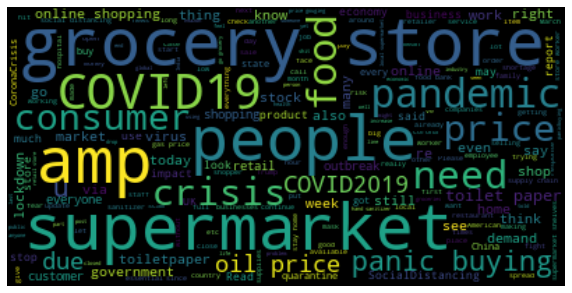

class: Positive


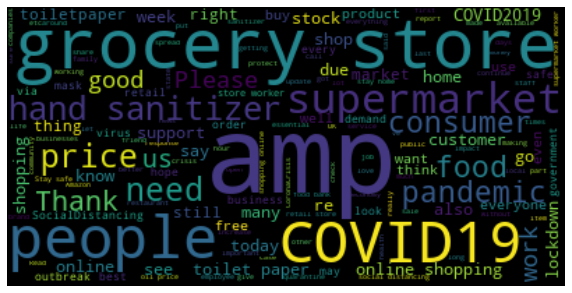

In [80]:
# WordCloud chart of each class
n = 0
y = data_pdf['Sentiment_2']
X = data_pdf[['OriginalTweet']]
for i in y.sort_values().unique():
    # Tạo text
    text = ""
    for j in X.iloc[y[y==y.unique()[n]].index].iloc[:,0]:
        text = text + " " + j
    # Bieu do WordCloud
    plt.figure(figsize=(10,10))
    wc_text=WordCloud(stopwords = stopwordList)
    wc_text.generate(text)
    print('class:',i)
    plt.imshow(wc_text,interpolation="bilinear")
    plt.axis("off")
    plt.show()
    n=n+1

## Train, Test Splitting

In [81]:
train_data, test_data = data.randomSplit([0.7,0.3])

In [82]:
train_data.count()

28832

In [83]:
test_data.count()

12325

In [84]:
train_data.columns

['UserName',
 'ScreenName',
 'Location',
 'TweetAt',
 'OriginalTweet',
 'Sentiment',
 'length',
 'Sentiment_2']

## Pipeline

In [85]:
# stopwords
# remover = StopWordsRemover(inputCol='ngrams', outputCol='filtered')
# stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

# stopwordList = ["new"] 
# stopwords = stopwords.union(set(STOPWORDS))
remover_2 = StopWordsRemover(inputCol='words', outputCol='filtered', stopWords=stopwordList)

# StringIndexer
indexer_2 = StringIndexer(inputCol='Sentiment_2',
                        outputCol='label')

In [86]:
# create pipelines
pipeline_nb_3 = Pipeline(stages=[regexTokenizer,
                                  remover_2,                                  
                                  cv,
                                  idf,
                                  assembler,
                                  indexer_2,
                                  nb])
pipeline_lg_3 = Pipeline(stages=[regexTokenizer,
                                  remover_2,
                                  cv,
                                  idf,
                                  assembler,
                                  indexer_2,
                                  lg])
pipeline_rf_3 = Pipeline(stages=[regexTokenizer,
                                  remover_2,
                                  cv,
                                  idf,
                                  assembler,
                                  indexer_2,
                                  rf])
pipeline_gbt_3 = Pipeline(stages=[regexTokenizer,
                                  remover_2,
                                  cv,
                                  idf,
                                  assembler,
                                  indexer_2,
                                  gbt])

## Build model  and evaluate

In [87]:
# train pipeline model with train_data
pipeline_nb_model_3 = pipeline_nb_3.fit(train_data)
pipeline_lg_model_3 = pipeline_lg_3.fit(train_data)
pipeline_rf_model_3 = pipeline_rf_3.fit(train_data)
pipeline_gbt_model_3 = pipeline_gbt_3.fit(train_data)

In [88]:
# predict with test data and built models
test_predictions_nb_3 = pipeline_nb_model_3.transform(test_data)
test_predictions_lg_3 = pipeline_lg_model_3.transform(test_data)
test_predictions_rf_3 = pipeline_rf_model_3.transform(test_data)
test_predictions_gbt_3 = pipeline_gbt_model_3.transform(test_data)

In [89]:
# evaluate built models one by one
lst_models_3 = [pipeline_nb_model_3, pipeline_lg_model_3, pipeline_rf_model_3, pipeline_gbt_model_3]
lst_acc_3=['acc']
lst_auc_3=['auc']
for i in lst_models_3:
  acc, auc, matrix = classification_evaluation(i, test_data, labelCol='label', predictionCol='prediction')
  lst_acc_3.append(acc)
  lst_auc_3.append(auc)

In [90]:
lst_acc_3

['acc',
 0.7179716024340771,
 0.7338742393509128,
 0.6477079107505072,
 0.7237322515212982]

In [91]:
lst_auc_3

['auc',
 0.4176754714720882,
 0.801889889475535,
 0.777734720681722,
 0.7657369252240239]

In [92]:
# show the evaluation results
col_names_3 = ['Metric name','NaiveBayes_3','LogisticRegression_3','RandomForest_3','Gradient-Boosted Trees_3']
summary_3 = [lst_acc_3, lst_auc_3]

# summary_df = pd.DataFrame.from_dict(dict(zip(col_names, metric_names)))
summary_df_3 = spark.createDataFrame(summary_3, col_names_3)
summary_df_3.show()

+-----------+------------------+--------------------+------------------+------------------------+
|Metric name|      NaiveBayes_3|LogisticRegression_3|    RandomForest_3|Gradient-Boosted Trees_3|
+-----------+------------------+--------------------+------------------+------------------------+
|        acc|0.7179716024340771|  0.7338742393509128|0.6477079107505072|      0.7237322515212982|
|        auc|0.4176754714720882|   0.801889889475535| 0.777734720681722|      0.7657369252240239|
+-----------+------------------+--------------------+------------------+------------------------+



In [93]:
# show confusion matrix of models, one by one
j=0
for i in lst_models_3:
  matrix = confusion_matrix(i, test_data, labelCol='label', predictionCol='prediction')
  print(col_names_3[j+1])
  print(matrix)
  j+=1

NaiveBayes_3
        0       1
0  5339.0  1539.0
1  1937.0  3510.0
LogisticRegression_3
        0       1
0  6233.0   645.0
1  2635.0  2812.0
RandomForest_3
        0       1
0  6728.0   150.0
1  4192.0  1255.0
Gradient-Boosted Trees_3
        0       1
0  6329.0   549.0
1  2856.0  2591.0


* According to acc and auc metrics. NaiveBayes is the best model
* Models with data removed stopwords are not better than models with original data
* Choosen models with changed labels and don't remove stopwords

# Cross Validation

In [95]:
# cross validation
lst_pipelines = [pipeline_nb_2, pipeline_lg_2, pipeline_rf_2, pipeline_gbt_2]
lst_acc_means=['acc_cv']
lst_auc_means=['auc_cv']
k=1
for i in lst_pipelines:
  lst_acc_cv=[]
  lst_auc_cv=[]
  for n in range(1,6):
    train_data, test_data = data.randomSplit([0.7,0.3])
    model = i.fit(train_data)
    acc, auc, matrix = classification_evaluation(model, test_data, labelCol='label', predictionCol='prediction')
    lst_acc_cv.append(acc)
    lst_auc_cv.append(auc)
  print(col_names_2[k])
  print(lst_acc_cv)
  print(lst_auc_cv)
  k+=1
  lst_acc_means.append(float(np.mean(lst_acc_cv)))
  lst_auc_means.append(float(np.mean(lst_auc_cv)))

NaiveBayes_2
[0.729630834281997, 0.7362619549359701, 0.7299447872685937, 0.7254806915495233, 0.7321385902031063]
[0.40473578775458297, 0.4055282248567324, 0.40203124497483134, 0.416125006011097, 0.4002547258241906]
LogisticRegression_2
[0.756150506512301, 0.7404292807944898, 0.7434614142718761, 0.7512523610084586, 0.7381028425423187]
[0.8228508558807661, 0.8163738040732599, 0.8219686810666723, 0.8262977317037266, 0.8140080040343473]
RandomForest_2
[0.6627794756313334, 0.6625419978693764, 0.6614858816828058, 0.6495963467340781, 0.6552824768592403]
[0.8030335715433341, 0.7977036772360773, 0.8046908089106892, 0.7963169222690704, 0.7996947027679635]
Gradient-Boosted Trees_2
[0.7448719987279376, 0.7449509521061742, 0.74375, 0.7371591371591372, 0.7410490584336863]
[0.7930819643672773, 0.79586984711474, 0.7929758526493327, 0.7940642616927269, 0.7955106633375212]


In [96]:
# type(np.mean(lst_acc_cv))

In [97]:
# type(float(np.mean(lst_acc_cv)))

In [98]:
# type(acc)

In [99]:
# show the evaluation results
col_names_2 = ['Metric name','NaiveBayes_2','LogisticRegression_2','RandomForest_2','Gradient-Boosted Trees_2']
summary_cv = [lst_acc_means, lst_auc_means]

# summary_df = pd.DataFrame.from_dict(dict(zip(col_names, metric_names)))
summary_df_cv = spark.createDataFrame(summary_cv, col_names_2)
summary_df_cv.show()

+-----------+-------------------+--------------------+------------------+------------------------+
|Metric name|       NaiveBayes_2|LogisticRegression_2|    RandomForest_2|Gradient-Boosted Trees_2|
+-----------+-------------------+--------------------+------------------+------------------------+
|     acc_cv| 0.7306913716478382|  0.7458792810258889|0.6583372357553668|       0.742356229285387|
|     auc_cv|0.40573499788428685|  0.8202998153517544| 0.800287936545427|      0.7943005178323196|
+-----------+-------------------+--------------------+------------------+------------------------+



* According to cross validation results, estimator performances of each models are good.

# Save model

In [100]:
# save models
pipeline_nb_model_2.write().overwrite().save('C2_Classification_pipeline_nb_CoronaviresTweets')
pipeline_lg_model_2.write().overwrite().save('C2_Classification_pipeline_lg_CoronaviresTweets')
pipeline_rf_model_2.write().overwrite().save('C2_Classification_pipeline_rf_CoronaviresTweets')
pipeline_gbt_model_2.write().overwrite().save('C2_Classification_pipeline_gbt_CoronaviresTweets')

# New data

In [101]:
# load models from
pipeline_nb_model_2_new = PipelineModel.load('C2_Classification_pipeline_nb_CoronaviresTweets')
pipeline_lg_model_2_new = PipelineModel.load('C2_Classification_pipeline_lg_CoronaviresTweets')
pipeline_rf_model_2_new = PipelineModel.load('C2_Classification_pipeline_rf_CoronaviresTweets')
pipeline_gbt_model_2_new = PipelineModel.load('C2_Classification_pipeline_gbt_CoronaviresTweets')

In [102]:
# read new data from given file
new_data = spark.read.format('csv').\
                  option("delimiter", ",").\
                  option("header","true").\
                  option("quote", "\"").\
                  option('escape','"').\
                  option("multiLine", "true").\
                  option("inferSchema", "true").\
                  option("parserLib", "UNIVOCITY").\
                  option("ignoreTrailingWhiteSpace","true").\
                  option("ignoreLeadingWhiteSpace", "true").\
                  load('Data/covid_text_classification/Corona_NLP_test.csv') 

In [103]:
new_data.show(5, False)

+--------+----------+-------------------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|UserName|ScreenName|Location           |TweetAt   |OriginalTweet                                                                                                                                                                                                                                                                                                                 |Sentiment         |
+--------+----------+-------------------+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [104]:
new_data.show(5, truncate=False, vertical=True)

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 UserName      | 1                                                                                                                                                                                                                                                                                                                              
 ScreenName    | 44953                                                                                                                                                                                                                                                                                                                

In [105]:
new_data.columns

['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet', 'Sentiment']

In [106]:
new_data.select('Sentiment').groupBy('Sentiment').count().show(truncate=False)

+------------------+-----+
|Sentiment         |count|
+------------------+-----+
|Extremely Negative|592  |
|Positive          |947  |
|Neutral           |619  |
|Negative          |1041 |
|Extremely Positive|599  |
+------------------+-----+



In [107]:
new_data.printSchema()

root
 |-- UserName: integer (nullable = true)
 |-- ScreenName: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- TweetAt: string (nullable = true)
 |-- OriginalTweet: string (nullable = true)
 |-- Sentiment: string (nullable = true)



In [108]:
# check NaN
new_data.select([sum(when(isnan(col(col_name)),1)
          .otherwise(0)).alias(col_name)
          for col_name in new_data.columns]).toPandas().T

,0
UserName,0
ScreenName,0
Location,0
TweetAt,0
OriginalTweet,0
Sentiment,0


In [109]:
# check null
new_data.select([sum(when(col(col_name).isNull(),1)
          .otherwise(0)).alias(col_name)
          for col_name in new_data.columns]).toPandas().T

,0
UserName,0
ScreenName,0
Location,835
TweetAt,0
OriginalTweet,0
Sentiment,0


In [110]:
# create "length" column
new_data = new_data.withColumn('length', length(new_data['OriginalTweet']))

In [111]:
# change the label column
# 2 classes
new_data = new_data.withColumn('Sentiment_2', when(col('Sentiment')=='Extremely Positive','Positive')
                                .when(col('Sentiment')=='Positive','Positive')
                                .when(col('Sentiment')=='Neutral','Negative')
                                .when(col('Sentiment')=='Negative','Negative')
                                .when(col('Sentiment')=='Extremely Negative','Negative')
                                .otherwise(''))

In [112]:
new_data.select('Sentiment_2').groupBy('Sentiment_2').count().show(truncate=False)

+-----------+-----+
|Sentiment_2|count|
+-----------+-----+
|Positive   |1546 |
|Negative   |2252 |
+-----------+-----+



In [113]:
# predict with new data and built models
new_predictions_nb = pipeline_nb_model_2_new.transform(new_data)
new_predictions_lg = pipeline_lg_model_2_new.transform(new_data)
new_predictions_rf = pipeline_rf_model_2_new.transform(new_data)
new_predictions_gbt = pipeline_gbt_model_2_new.transform(new_data)

In [114]:
# evaluate built models one by one
lst_models_new = [pipeline_nb_model_2_new, pipeline_lg_model_2_new, pipeline_rf_model_2_new, pipeline_gbt_model_2_new]
lst_acc_new=['acc']
lst_auc_new=['auc']
for i in lst_models_new:
  acc, auc, matrix = classification_evaluation(i, test_data, labelCol='label', predictionCol='prediction')
  lst_acc_new.append(acc)
  lst_auc_new.append(auc)

In [115]:
lst_acc_new

['acc',
 0.7366038955790835,
 0.7488887092863493,
 0.6547320779115817,
 0.7469490018588862]

In [116]:
lst_auc_new

['auc',
 0.41102828448289574,
 0.8273283740729448,
 0.8025119806824771,
 0.8032690166828362]

In [120]:
# show the evaluation results
col_names_new = ['Metric name','NaiveBayes_2_new','LogisticRegression_2_new','RandomForest_2_new', 'Gradient-Boosted Trees_2_new']
summary_new = [lst_acc_3, lst_auc_3]

# summary_df = pd.DataFrame.from_dict(dict(zip(col_names, metric_names)))
summary_df_new = spark.createDataFrame(summary_new, col_names_new)
summary_df_new.show()

+-----------+------------------+------------------------+------------------+----------------------------+
|Metric name|  NaiveBayes_2_new|LogisticRegression_2_new|RandomForest_2_new|Gradient-Boosted Trees_2_new|
+-----------+------------------+------------------------+------------------+----------------------------+
|        acc|0.7179716024340771|      0.7338742393509128|0.6477079107505072|          0.7237322515212982|
|        auc|0.4176754714720882|       0.801889889475535| 0.777734720681722|          0.7657369252240239|
+-----------+------------------+------------------------+------------------+----------------------------+



In [121]:
# show confusion matrix of models, one by one
j=0
for i in lst_models_new:
  matrix = confusion_matrix(i, new_data, labelCol='label', predictionCol='prediction')
  print(col_names_new[j+1])
  print(matrix)
  j+=1

NaiveBayes_2_new
        0      1
0  1826.0  426.0
1   568.0  978.0
LogisticRegression_2_new
        0      1
0  2053.0  199.0
1   737.0  809.0
RandomForest_2_new
        0      1
0  2206.0   46.0
1  1242.0  304.0
Gradient-Boosted Trees_2_new
        0      1
0  2003.0  249.0
1   730.0  816.0


* NaiveBayes is good when predicting the new data

In [122]:
data.unpersist()

DataFrame[UserName: int, ScreenName: int, Location: string, TweetAt: string, OriginalTweet: string, Sentiment: string, length: int, Sentiment_2: string]

In [123]:
end_time = time.time()

In [124]:
duration = (end_time - start_time)/60
duration = int(duration)

In [125]:
print('Total time for model training is about', duration, 'minutes')

Total time for model training is about 37 minutes
